In [1]:
import ultraplot as uplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from shapely import wkt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import rasterio.mask as rmask
from shapely import Polygon

from matplotlib.patches import Polygon as mplPolygon

# Prepare map data

In [2]:
mt_pleasant2_2021 = rio.open('./Data/Defol_Eval/defol_eval_mt_pleasant2_2021.tif')
positive_2021 = rio.open('./Data/Defol_Eval/defol_eval_positive_2021.tif')
negative_2021 = rio.open('./Data/Defol_Eval/defol_eval_negative_2021.tif')
mt_pleasant2_2020 = rio.open('./Data/Defol_Eval/defol_eval_mt_pleasant2_2020.tif')
positive_2020 = rio.open('./Data/Defol_Eval/defol_eval_positive_2020.tif')
negative_2020 = rio.open('./Data/Defol_Eval/defol_eval_negative_2020.tif')
aerial = gpd.read_file('./Data/SpongyMoth.gdb')

In [3]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    #new_image = np.concatenate([new_image, new_image, new_image])
    new_image = new_image.transpose([1, 2, 0])
    new_image[:, :, 0:3] = np.clip(new_image[:, :, 0:3] / 1000, 0, 1)
    
    # Create a nan mask
    alpha_channel = ~np.isnan(new_image[:, :, [0]])
    new_image = np.concatenate([new_image, alpha_channel], axis=2)

    return new_image, new_bounds

mtp2_2021_reproj, mtp2_2021_reproj_bounds = prepare_for_viz(mt_pleasant2_2021, dest_crs)
pos_2021_reproj, pos_2021_reproj_bounds = prepare_for_viz(positive_2021, dest_crs)
neg_2021_reproj, neg_2021_reproj_bounds = prepare_for_viz(negative_2021, dest_crs)

mtp2_2020_reproj, mtp2_2020_reproj_bounds = prepare_for_viz(mt_pleasant2_2020, dest_crs)
pos_2020_reproj, pos_2020_reproj_bounds = prepare_for_viz(positive_2020, dest_crs)
neg_2020_reproj, neg_2020_reproj_bounds = prepare_for_viz(negative_2020, dest_crs)

In [4]:
positive_aerial = aerial[aerial['GlobalID'] == '{E6D64476-3ECA-485D-B7BB-FB9C234F4A0D}'].union_all()

In [5]:
negative_aerial = aerial[aerial['GlobalID'] == '{766ED619-AD4B-43E9-81D2-B612736676F9}'].union_all()

# Prepare plot data

In [6]:
def prepare_data(area_filepath, year):
    # Load Data
    area = pd.read_csv(area_filepath)
    val_polygons = gpd.read_file('./Data/SpongyMoth.gdb')
    val_polygons = val_polygons[val_polygons['year'] == year]

    # Reproject data
    dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)
    counties = gpd.read_file('./Data/counties_2021.geojson')
    counties = counties.to_crs(dest_crs)[['ADM2_NAME', 'geometry']]
    val_polygons = val_polygons.to_crs(dest_crs)
    
    # Estimate county-level Aerial Survey estimates
    county_AS_ests = [val_polygons.intersection(county.geometry).area.sum() for county in counties.itertuples()]
    
    combined = gpd.GeoDataFrame(pd.concat([area, counties], axis=1))
    combined['AS_total_area'] = county_AS_ests
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    return combined

In [7]:
combined = prepare_data('./Data/Enviro/defol_area_county_2021.csv', 2021)

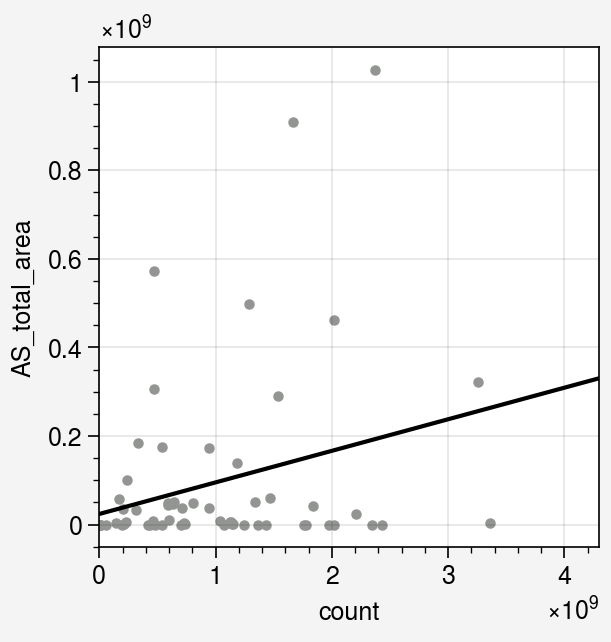

In [8]:
fig, ax = uplt.subplots()

coef = np.polyfit(combined['count']*100,combined['AS_total_area'],1)
poly1d_fn = np.poly1d(coef) 

ax.scatter(combined['count']*100, combined['AS_total_area'], color='gray', markersize=10)

x = np.array([0, 4.3*10**9])
ax.plot(x, poly1d_fn(x), color='black')

ax.format(xlim=[0, 4.3*10**9])

In [9]:
common = 2929283.301960784
aerial = 19169746
satellite = 21736131.690196082

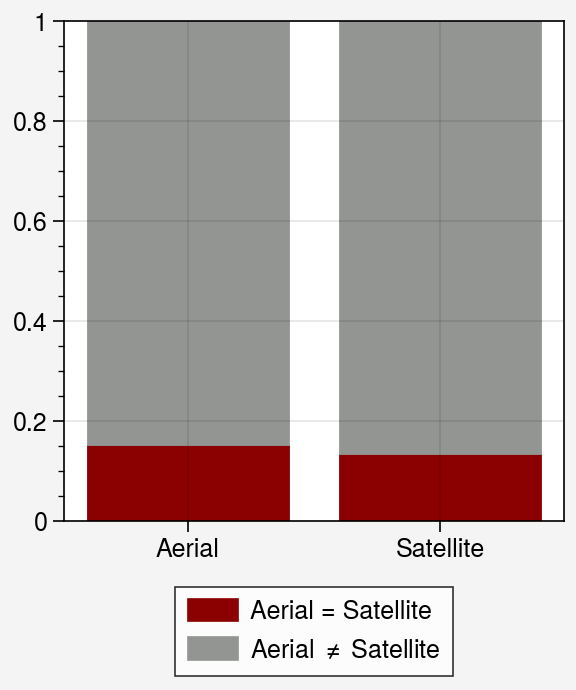

In [10]:
fig, ax = uplt.subplots()

ax.bar([[common/aerial, 1 - common/aerial], [common/satellite, 1 - common/satellite]], stacked=True, cycle=['darkred', 'gray'])

ax.format(xlocator=[0, 1], xticklabels=['Aerial', 'Satellite'], xminorlocator='null', ylim=[0, 1])

matched = mpatches.Patch(color='darkred', label='Aerial = Satellite')
unmatched = mpatches.Patch(color='gray', label=r'Aerial $\neq$ Satellite')
fig.legend(handles=[matched, unmatched], loc='b', ncols=1)

# Make Figure

In [11]:
# Take an image, a nan color, and a palette for an integer valued array (expressed as 2-d array of color values)
def apply_palette(image, nan_color, palette):
    nan_image = np.tile(np.array([[[0, 0, 0, 0]]]), (image.shape[0], image.shape[1], 1))
    sanitized_image = np.nan_to_num(image).astype(int)
    
    nan_test = np.tile(np.isnan(image), (4, 1, 1)).transpose([1, 2, 0])
    return np.where(nan_test, nan_image, palette[sanitized_image])

In [12]:
def plot_condition(ax, image, crs, extent, poly=None):
    ax.imshow(image[:, :, [0, 1, 2, -1]])#, transform=crs, origin='upper', extent=extent, zorder=0)

    # Mask out other classes first.
    data = np.where(np.isnan(image[:, :, 4]) & np.isnan(image[:, :, 5]) & np.isnan(image[:, :, 6]),
                    image[:, :, 3], np.nan)
    
    # Add Defoliation classes
    defol_palette = np.array([[0, 0, 0, 0],
                              [255, 0, 0, 255]])
    defol = apply_palette(data, [0, 0, 0, 0], defol_palette)
    ax.imshow(defol, zorder=2, origin='upper')#, transform=crs, extent=extent)
    #ax.format(xlocator='null', ylocator='null')

    bad_palette = np.array([[0, 0, 0, 0],
                            [0, 0, 0, 255]])
    # Add Landcover
    
    landcover = apply_palette(image[:, :, 4], [0, 0, 0, 0], bad_palette)
    ax.imshow(landcover, zorder=3, transform=crs, origin='upper',
              extent=extent)

    # Add Logging
    logging = apply_palette(image[:, :, 5], [0, 0, 0, 0], bad_palette)
    ax.imshow(logging, zorder=2, transform=crs, origin='upper',
              extent=extent)

    # Add Observation
    obs = apply_palette(image[:, :, 6], [0, 0, 0, 0], bad_palette)
    ax.imshow(obs, zorder=2, transform=crs, origin='upper',
              extent=extent)
    
    if poly is not None:
        p = mplPolygon(positive_aerial.exterior.coords, edgecolor='black', facecolor='none', zorder=3)
        ax.add_patch(p)
        #ax.add_geometries([poly], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree(), zorder=3)
    
    #ax.set_extent(extent, crs=crs)

In [13]:
def plot_condition(ax, image, crs, extent, poly=None):
    ax.imshow(image[:, :, [0, 1, 2, -1]], transform=crs, origin='upper', extent=extent, zorder=0)

    # Mask out other classes first.
    data = np.where((image[:, :, 4]==0) & (image[:, :, 5]==0) & (image[:, :, 6]==0),
                    image[:, :, 3], 0)
    
    # Add Defoliation classes
    defol_palette = np.array([[0, 0, 0, 0],
                              [255, 0, 0, 255]])
    defol = apply_palette(data, [0, 0, 0, 0], defol_palette)
    ax.imshow(defol, zorder=2, origin='upper', transform=crs, extent=extent)

    # bad_palette = np.array([[0, 0, 0, 0],
    #                         [0, 0, 0, 255]])

    # landcover = apply_palette(image[:, :, 4], [0, 0, 0, 0], bad_palette)
    # ax.imshow(landcover, zorder=3, transform=crs, origin='upper',
    #           extent=extent)

    # # Add Logging
    # logging = apply_palette(image[:, :, 5], [0, 0, 0, 0], bad_palette)
    # ax.imshow(logging, zorder=2, transform=crs, origin='upper',
    #           extent=extent)

    # # Add Observation
    # obs = apply_palette(image[:, :, 6], [0, 0, 0, 0], bad_palette)
    # ax.imshow(obs, zorder=2, transform=crs, origin='upper',
    #           extent=extent)
    
    if poly is not None:
        #p = mplPolygon(positive_aerial.exterior.coords, edgecolor='black', facecolor='none', zorder=3)
        ax.add_geometries([poly], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree(), zorder=3)
    
    ax.set_extent(extent, crs=crs)

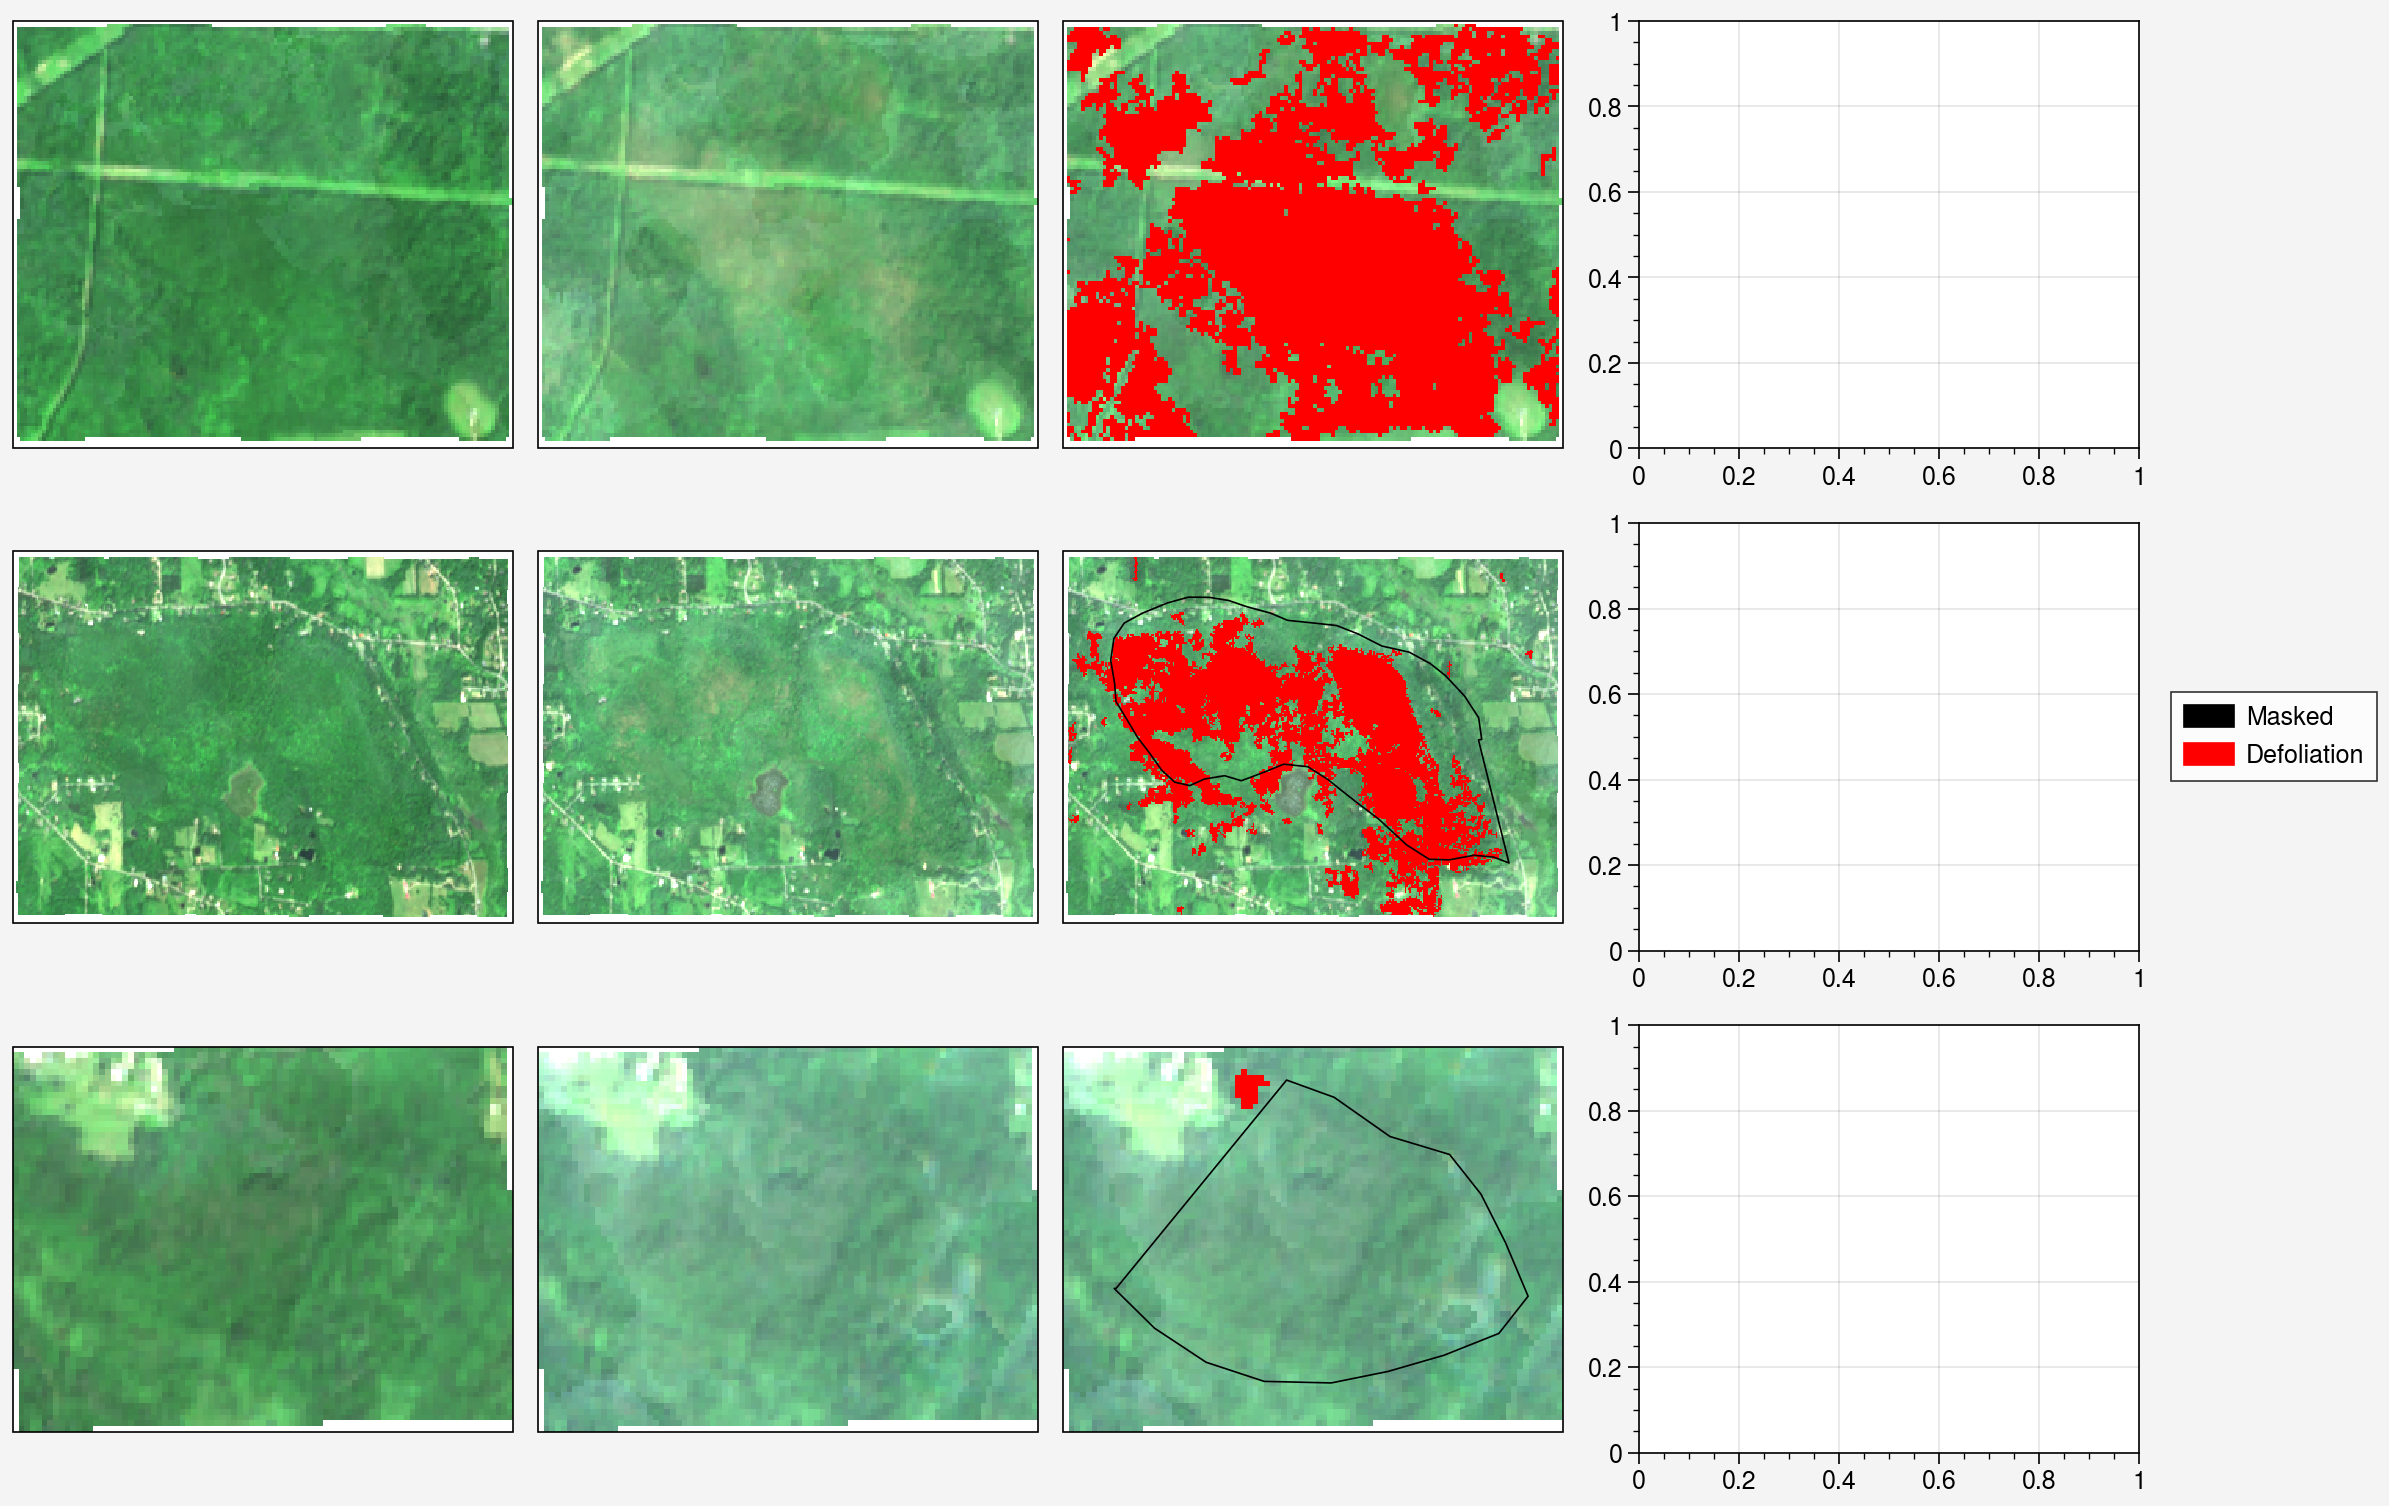

In [14]:
fig, axes = uplt.subplots(ncols=4, nrows=3, share=False, proj={(1, 2, 3, 5, 6, 7, 9, 10, 11):dest_crs})

# Mt. Pleasant
mp_extent = [mtp2_2021_reproj_bounds[0], mtp2_2021_reproj_bounds[2], mtp2_2021_reproj_bounds[1], mtp2_2021_reproj_bounds[3]]
## Add 2020
axes[0].imshow(mtp2_2020_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=mp_extent)
axes[0].set_extent(mp_extent, crs=dest_crs)
## Add 2021
axes[1].imshow(mtp2_2021_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=mp_extent)
axes[1].set_extent(mp_extent, crs=dest_crs)
## Add Defol Plot
plot_condition(axes[2], mtp2_2021_reproj, dest_crs,
               mp_extent)

# Positive
pos_extent = [pos_2021_reproj_bounds[0], pos_2021_reproj_bounds[2], pos_2021_reproj_bounds[1], pos_2021_reproj_bounds[3]]
## Add 2020
axes[4].imshow(pos_2020_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=pos_extent)
axes[4].set_extent(pos_extent, crs=dest_crs)
## Add 2021
axes[5].imshow(pos_2021_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=pos_extent)
axes[5].set_extent(pos_extent, crs=dest_crs)
## Add Defol Plot
plot_condition(axes[6], pos_2021_reproj, dest_crs,
               pos_extent, positive_aerial)

# Negative
neg_extent = [neg_2021_reproj_bounds[0], neg_2021_reproj_bounds[2], neg_2021_reproj_bounds[1], neg_2021_reproj_bounds[3]]
## Add 2020
axes[8].imshow(neg_2020_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=neg_extent)
axes[8].set_extent(neg_extent, crs=dest_crs)
## Add 2021
axes[9].imshow(neg_2021_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=neg_extent)
axes[9].set_extent(neg_extent, crs=dest_crs)
## Add Defol Plot
plot_condition(axes[10], neg_2021_reproj, dest_crs,
               neg_extent, negative_aerial)

# Create legend
landcover_patch = mpatches.Patch(color=[0,0,0], label='Masked')
defol_patch = mpatches.Patch(color=[1,0,0], label='Defoliation')
fig.legend(handles=[landcover_patch, defol_patch], loc='r', ncols=1)


#fig.savefig('./Figures/Defol_Eval/New_York_study_site_comparison.png')

In [15]:
layout = [[1, 2, 3, None],
          [1, 2, 3, 10],
          [4, 5, 6, 10],
          [4, 5, 6, 11],
          [7, 8, 9, 11],
          [7, 8, 9, None]]

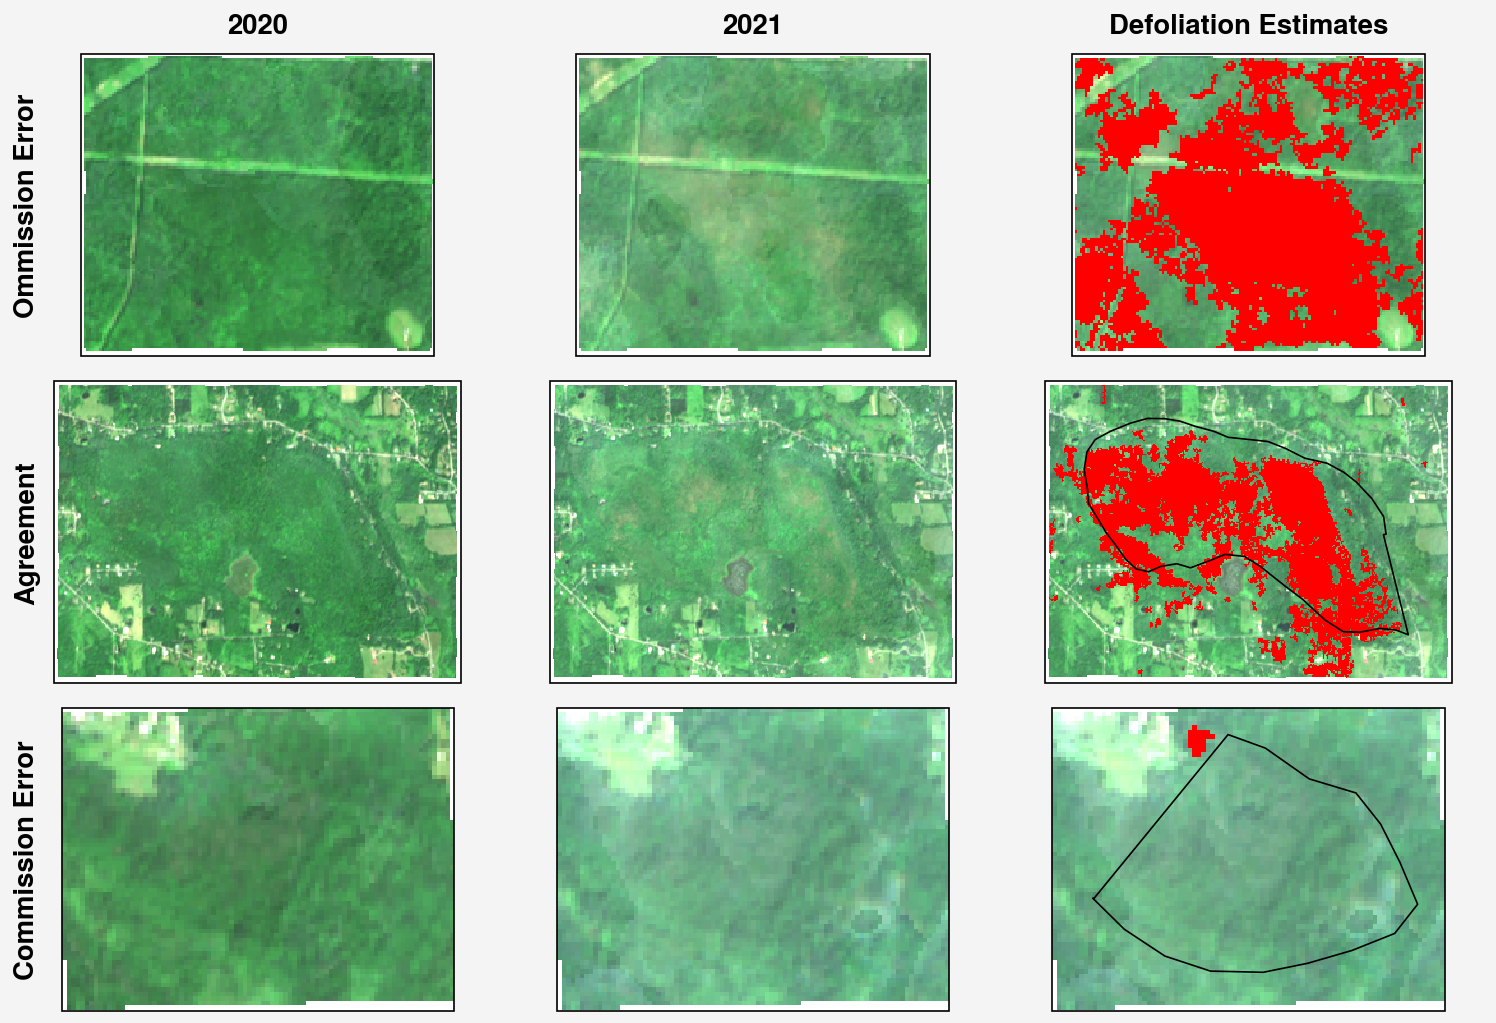

In [16]:
fig, axes = uplt.subplots(nrows=3, ncols=3, proj=dest_crs, figsize=('190mm', '130mm'))

# Mt. Pleasant
mp_extent = [mtp2_2021_reproj_bounds[0], mtp2_2021_reproj_bounds[2], mtp2_2021_reproj_bounds[1], mtp2_2021_reproj_bounds[3]]
## Add 2020
axes[0].imshow(mtp2_2020_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=mp_extent)
axes[0].set_extent(mp_extent, crs=dest_crs)
## Add 2021
axes[1].imshow(mtp2_2021_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=mp_extent)
axes[1].set_extent(mp_extent, crs=dest_crs)
## Add Defol Plot
plot_condition(axes[2], mtp2_2021_reproj, dest_crs,
               mp_extent)

# Positive
pos_extent = [pos_2021_reproj_bounds[0], pos_2021_reproj_bounds[2], pos_2021_reproj_bounds[1], pos_2021_reproj_bounds[3]]
## Add 2020
axes[3].imshow(pos_2020_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=pos_extent)
axes[3].set_extent(pos_extent, crs=dest_crs)
## Add 2021
axes[4].imshow(pos_2021_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=pos_extent)
axes[4].set_extent(pos_extent, crs=dest_crs)
## Add Defol Plot
plot_condition(axes[5], pos_2021_reproj, dest_crs,
               pos_extent, positive_aerial)

# Negative
neg_extent = [neg_2021_reproj_bounds[0], neg_2021_reproj_bounds[2], neg_2021_reproj_bounds[1], neg_2021_reproj_bounds[3]]
## Add 2020
axes[6].imshow(neg_2020_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=neg_extent)
axes[6].set_extent(neg_extent, crs=dest_crs)
## Add 2021
axes[7].imshow(neg_2021_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs, extent=neg_extent)
axes[7].set_extent(neg_extent, crs=dest_crs)
## Add Defol Plot
plot_condition(axes[8], neg_2021_reproj, dest_crs,
               neg_extent, negative_aerial)

axes.format(leftlabels=('Ommission Error', 'Agreement', 'Commission Error'), toplabels=('2020', '2021', 'Defoliation Estimates'))

fig.savefig('./Figures/Defol_Eval/pos_neg_compare_V1.png')

In [17]:
np.unique(pos_2020_reproj[:,:,3])

array([ 0.,  1., nan], dtype=float32)

In [18]:
np.sum(pos_2020_reproj[:,:,3] == 1)

np.int64(26)